In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y %b'))
from typing import Union
from pathlib import Path
from datetime import datetime
from tqdm.notebook import tqdm
from itertools import product
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## iNGEST

the dataset is gotten from [city of chicago website](https://data.cityofchicago.org/Transportation/CTA-Ridership-Daily-Boarding-Totals/6iiy-9s97/about_data)

In [3]:
# Ingest the data
def ingest_chicago_ridership():
    path = Path("datasets/ridership_new/CTA_-_Ridership_-_Daily_Boarding_Totals_20240528.csv")
    # read dataset
    df = pd.read_csv(path, parse_dates=["service_date"])
    # rename some columns
    df.rename(columns={
        "service_date": "date",
        "rail_boardings": "rail"
    }, inplace=True)
    # sort by date
    df = df.sort_values("date").set_index("date")
    # drop the duplicates
    df.drop_duplicates(keep='first', inplace=True)
    # index the data from 2020 till the end of the dataset
    df = df.loc["2020-1-1":]
    # the ferqunecy is daily
    df = df.asfreq("D")
    
    return df

In [4]:
df = ingest_chicago_ridership()
df.shape
df.head()

(1521, 4)

,day_type,bus,rail,total_rides
date,,,,
2020-01-01,U,267300,255759,523059
2020-01-02,W,651421,565139,1216560
2020-01-03,W,688165,578202,1266367
2020-01-04,A,409243,306656,715899
2020-01-05,U,314424,234155,548579


In [5]:
df.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2024-02-20', '2024-02-21', '2024-02-22', '2024-02-23',
               '2024-02-24', '2024-02-25', '2024-02-26', '2024-02-27',
               '2024-02-28', '2024-02-29'],
              dtype='datetime64[ns]', name='date', length=1521, freq='D')

## EDA

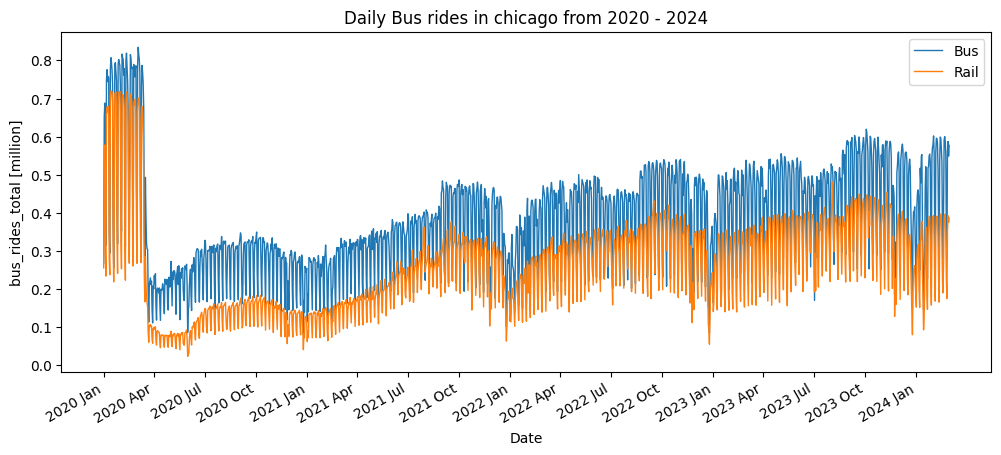

In [8]:
# The entire dataset as is
fig, ax = plt.subplots(figsize=(12, 5))

# Line plot
ax.plot(df.index, df["bus"]/1e6, label="Bus", linestyle="-", linewidth=1)
ax.plot(df.index, df["rail"]/1e6, label="Rail", linestyle="-", linewidth=1)

# Set labels and title
ax.set_xlabel("Date")
ax.set_ylabel("bus_rides_total [million]")
ax.set_title("Daily Bus rides in chicago from 2020 - 2024")

start_date = df.index[0]
end_date = df.index[-1]

plt.xticks(pd.date_range(start=start_date, end=end_date, freq="QS", inclusive='both'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y %b'))

ax.legend()
fig.autofmt_xdate();

I can deduce that the data is not very stationary. Things are trying to go back to normal i.e as they used to be before the pandemic) so the data seems to be in a subtle uptrend  
This is more obvious for the bus than it is for the rail

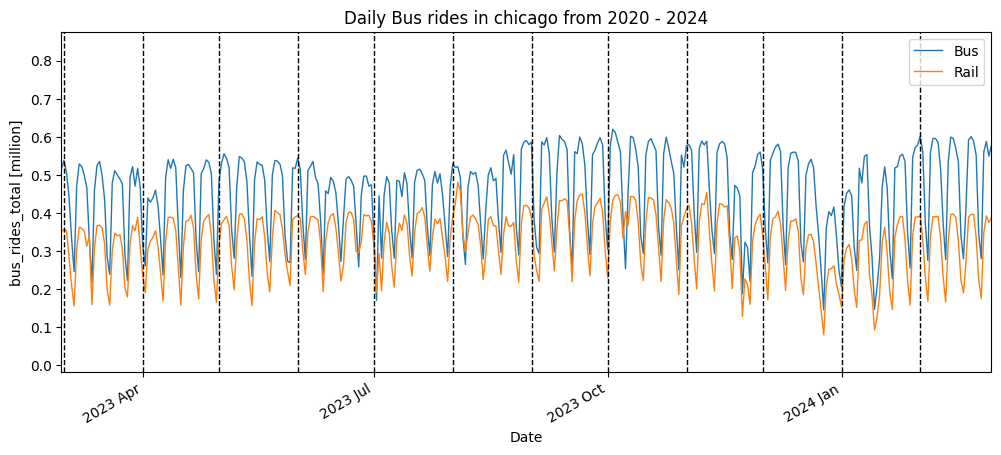

In [9]:
# From 2023 - 2024
fig, ax = plt.subplots(figsize=(12, 5))

# Line plot
ax.plot(df.index, df["bus"]/1e6, label="Bus", linestyle="-", linewidth=1)
ax.plot(df.index, df["rail"]/1e6, label="Rail", linestyle="-", linewidth=1)

# Set labels and title
ax.set_xlabel("Date")
ax.set_ylabel("bus_rides_total [million]")
ax.set_title("Daily Bus rides in chicago from 2023 Feb - 2024 Feb")

start_date = datetime(2023, 2, 28)
end_date = datetime(2024, 2, 29)

# Zoom
plt.xlim(xmin=start_date, xmax=end_date)

for i in pd.date_range(start=start_date, end=end_date, freq="MS", inclusive='both'):
            ax.axvline(x=i, linestyle='--', color='black', linewidth=1)

plt.xticks(pd.date_range(start=start_date, end=end_date, freq="QS", inclusive='both'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y %b'))

ax.legend()
fig.autofmt_xdate();

## Test for stationarity

In [10]:
df.head()

,day_type,bus,rail,total_rides
date,,,,
2020-01-01,U,267300,255759,523059
2020-01-02,W,651421,565139,1216560
2020-01-03,W,688165,578202,1266367
2020-01-04,A,409243,306656,715899
2020-01-05,U,314424,234155,548579


In [11]:
# Test for stationarity bus
ADF_result_bus = adfuller(df["bus"])
print(f'ADF Statistic for bus: {ADF_result_bus[0]}')
print(f'p-value: {ADF_result_bus[1]}')
print()
# Test for stationarity Rail
ADF_result_rail = adfuller(df["rail"])
print(f'ADF Statistic for rail: {ADF_result_rail[0]}')
print(f'p-value: {ADF_result_rail[1]}')

ADF Statistic for bus: -3.2845617247564816
p-value: 0.01558282834342694

ADF Statistic for rail: -3.3909097276838462
p-value: 0.011272689396411689


The p value is < 0.05  
Therefore we reject the null hypothesis and conclude tha the data is stationary

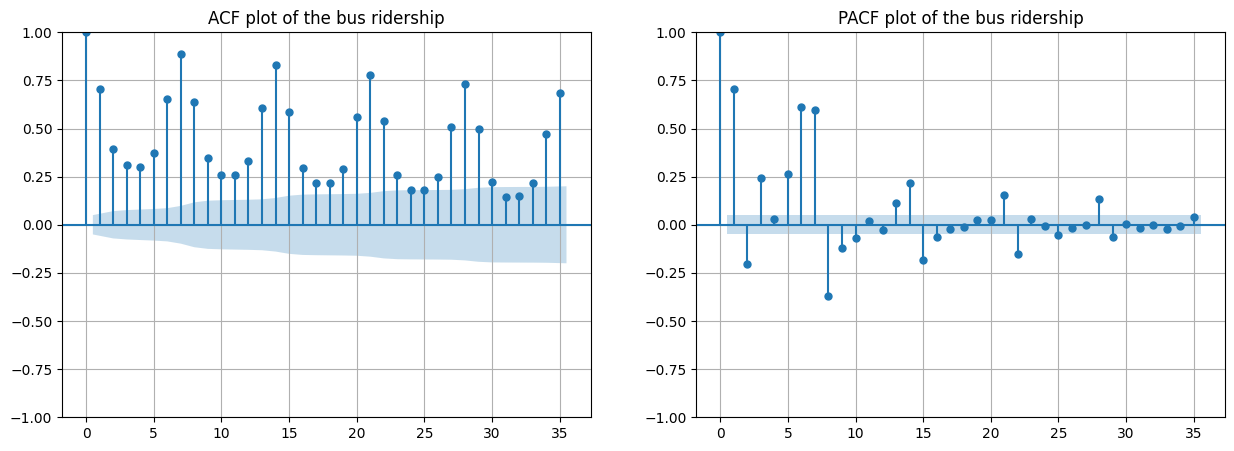

In [12]:
# Plot the Autocorrelation Function (ACF) and thePartial Autocorrelation Function (PACF)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(df["bus"], ax=axs[0], lags=35, title="ACF plot of the bus ridership")
axs[0].grid()
plot_pacf(df["bus"], ax=axs[1], lags=35, method="ywm", title="PACF plot of the bus ridership")
axs[1].grid()
plt.show();

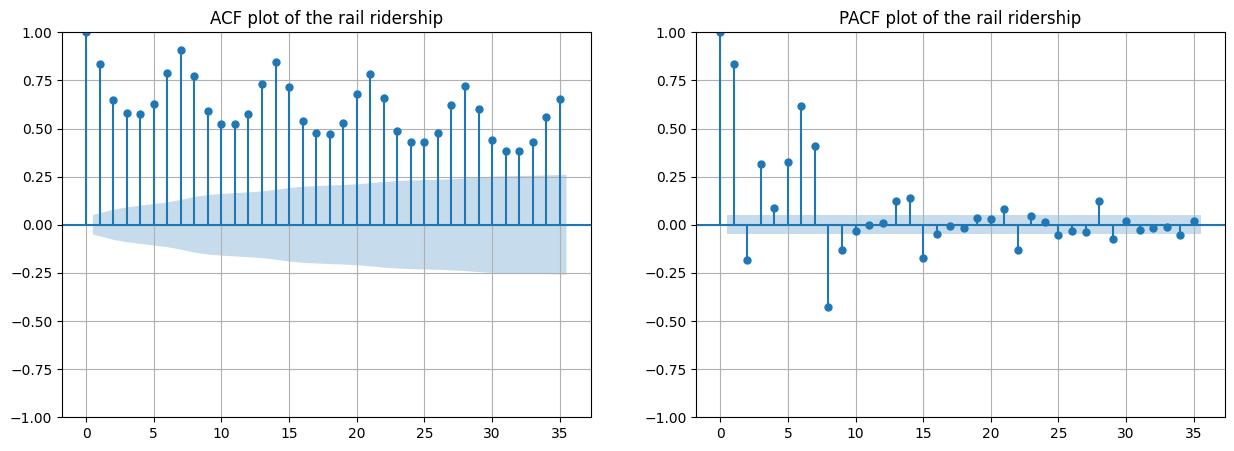

In [13]:
# Plot the Autocorrelation Function (ACF) and thePartial Autocorrelation Function (PACF)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(df["rail"], ax=axs[0], lags=35, title="ACF plot of the rail ridership")
axs[0].grid()
plot_pacf(df["rail"], ax=axs[1], lags=35, method="ywm", title="PACF plot of the rail ridership")
axs[1].grid()
plt.show();

+ The present is correlated with past values. i.e They are not random walks
+ The coefficients are high, low, then high again. This is recurring. i.e There is a strong short term trend in the data
+ The data displays cyclical patterns i.e The data is seasonal

## Decompostition

In [14]:
# The data is daily and i see a strong weekly seasonality. so i set the period to 7
rail_decomposition = STL(df["rail"], period=7).fit()

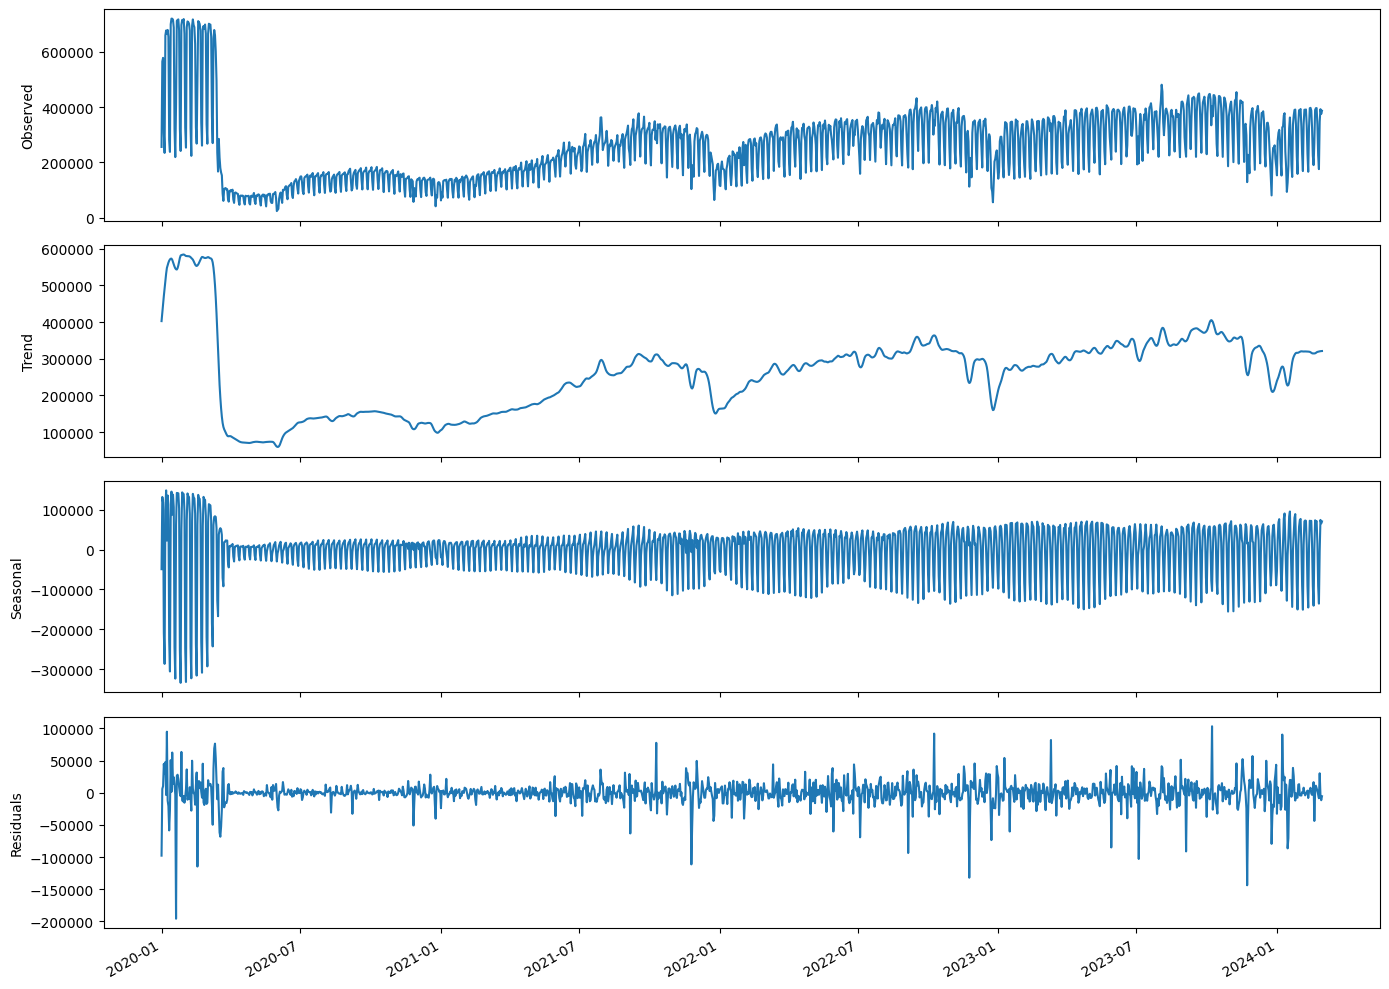

In [15]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(14, 10))

ax1.plot(rail_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(rail_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(rail_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(rail_decomposition.resid)
ax4.set_ylabel('Residuals')

fig.autofmt_xdate()
plt.tight_layout();

The weekly seasonality is clear. 
The seasonality is starting to expand. i.e the peak of the trend is getting higher and the through is getting lower. 
The data is trying to come back to normal although we cannot know whether it will. The pandemic cahanged alot of things

In [16]:
# The data is daily and i see a strong weekly seasonality. so i set the period to 7
bus_decomposition = STL(df["bus"], period=7).fit()

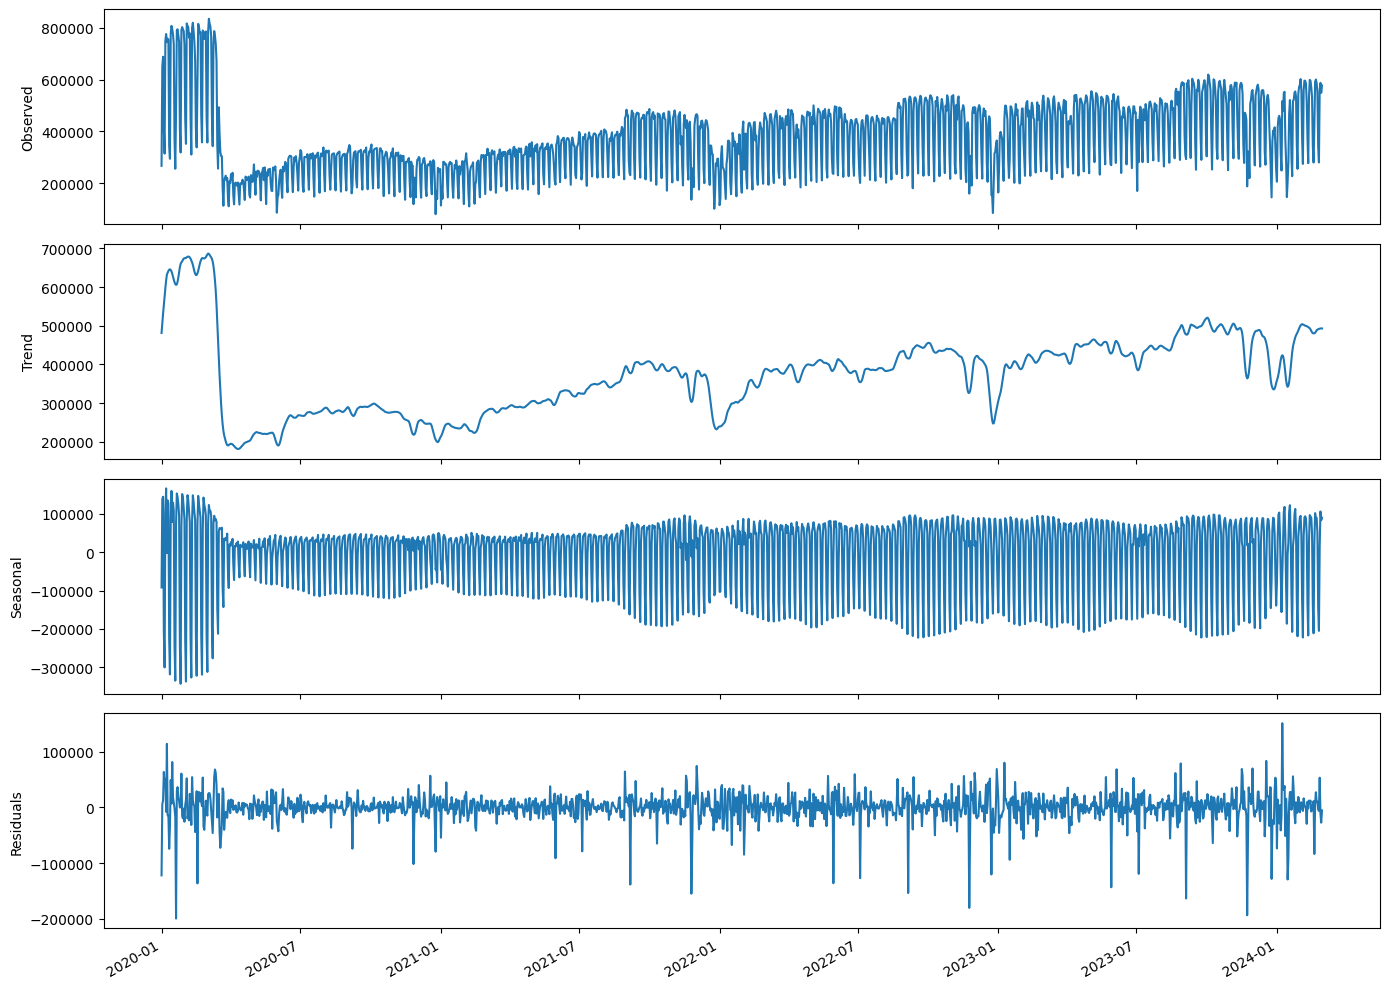

In [17]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(14, 10))

ax1.plot(bus_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(bus_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(bus_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(bus_decomposition.resid)
ax4.set_ylabel('Residuals')

fig.autofmt_xdate()
plt.tight_layout();

## Train test split

To be safe. The training data cannot go below January 1st of 2021.
Our main goal is to predict 14 days of data in in advance


The training dataset will be 3 years i.e 2013/08/01 --- 2016/08/01
validation dataset will be 1 year i.e 2016/08/02 --- 2017/08/02
the test data will be 1 year i.e 2017/08/03 --- 2018/08/03

In [18]:
from datetime import timedelta

In [19]:
test_set_end = df.index[-1]
test_set_start = test_set_end - timedelta(13)
val_set_end = test_set_start - timedelta(1)
val_set_start = val_set_end - timedelta(13)
train_set_end = val_set_start - timedelta(1)
train_set_start = val_set_start - timedelta(356)

print(f"Train set: {train_set_start} - {train_set_end}")
print(f"Validation set: {val_set_start} - {val_set_end}")
print(f"Test set: {test_set_start} - {test_set_end}")

Train set: 2023-02-11 00:00:00 - 2024-02-01 00:00:00
Validation set: 2024-02-02 00:00:00 - 2024-02-15 00:00:00
Test set: 2024-02-16 00:00:00 - 2024-02-29 00:00:00


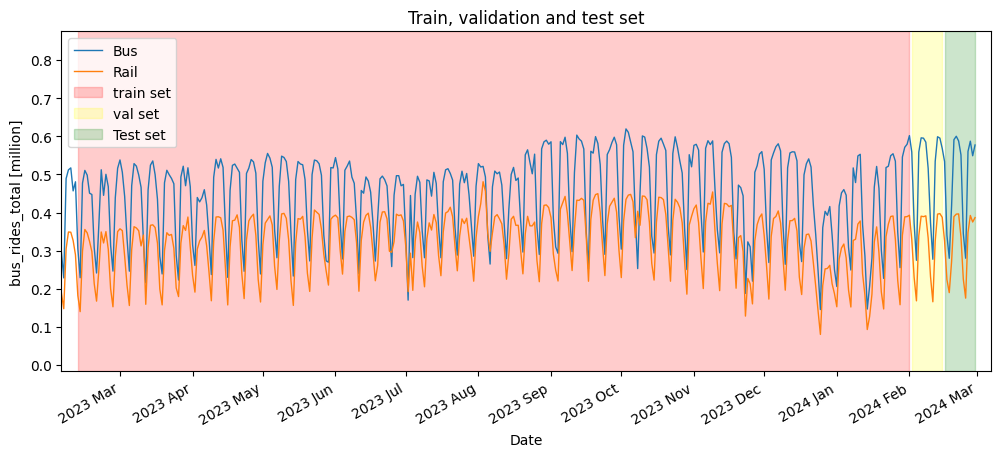

In [20]:
# The entire dataset as is
fig, ax = plt.subplots(figsize=(12, 5))

# Line plot
ax.plot(df.index, df["bus"]/1e6, label="Bus", linestyle="-", linewidth=1)
ax.plot(df.index, df["rail"]/1e6, label="Rail", linestyle="-", linewidth=1)

# Set labels and title
ax.set_xlabel("Date")
ax.set_ylabel("bus_rides_total [million]")
ax.set_title("Train, validation and test set")

start_date = train_set_start - timedelta(7)
end_date = test_set_end + timedelta(7)

# Zoom
plt.xlim(xmin=start_date, xmax=end_date)

ax.axvspan(train_set_start, train_set_end, color='red', alpha=0.2, label="train set") # Train set
ax.axvspan(val_set_start, val_set_end, color='yellow', alpha=0.2, label="val set") # Val set
ax.axvspan(test_set_start, test_set_end, color='green', alpha=0.2, label="Test set") # Test set

plt.xticks(pd.date_range(start=start_date, end=end_date, freq="MS", inclusive='both'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y %b'))

ax.legend()
fig.autofmt_xdate();

Before splitting into train, val and test set. We will shift the day type one day into the past. since it is possible to predict it in advance.

In [21]:
df.head()

,day_type,bus,rail,total_rides
date,,,,
2020-01-01,U,267300,255759,523059
2020-01-02,W,651421,565139,1216560
2020-01-03,W,688165,578202,1266367
2020-01-04,A,409243,306656,715899
2020-01-05,U,314424,234155,548579


In [ ]:
df['tmmrw_day_type'] = df.loc[:, ['day_type']].shift(-1)
df.drop(columns=["day_type"], inplace=True)
df.head()

In [ ]:
df.tail()

In [ ]:
# Drop day type column
df = pd.get_dummies(df)  # one-hot encode the day type
df.head()

In [ ]:
def bool_to_int(df):
    df = df.copy()
    df["tmmrw_day_type_A"] = df.loc[:, "tmmrw_day_type_A"].astype(int)
    df["tmmrw_day_type_U"] = df.loc[:, "tmmrw_day_type_U"].astype(int)
    df["tmmrw_day_type_W"] = df.loc[:, "tmmrw_day_type_W"].astype(int)
    return df 

In [ ]:
df = bool_to_int(df)
df.head()

In [22]:
# Now aggregate the train, validation and test set
train_set = df.loc[train_set_start:train_set_end]
val_set = df.loc[val_set_start:val_set_end]
test_set = df.loc[test_set_start:test_set_end]

In [23]:
# Confirm that the frequency is Daily. Statmodels will bring up a warning if this is not defined
assert train_set.index.freq == "D"
assert val_set.index.freq == "D"
assert test_set.index.freq == "D"

In [24]:
train_set.shape, val_set.shape, test_set.shape

((356, 4), (14, 4), (14, 4))

In [ ]:
# create the train, valid
bus_train_set = train_set.loc[:, "bus"]
bus_val_set = val_set.loc[:, "bus"]
bus_test_set = test_set.loc[:, 'bus']

rail_train_set = train_set.loc[:, "rail"]
rail_val_set = val_set.loc[:, "rail"]
rail_test_set = test_set.loc[:, 'rail']

exogenous_columns = ["tmmrw_day_type_A", "tmmrw_day_type_U", "tmmrw_day_type_W"]
train_exog = train_set.loc[:, exogenous_columns]
val_exog = val_set.loc[:, exogenous_columns]
test_exog = test_set.loc[:, exogenous_columns]

## Hyperparameter tuning with SARIMAX

In [32]:
def optimize_SARIMA(
    endog: Union[pd.Series, list], 
    exog: Union[pd.Series, list], 
    order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm(order_list):
        try: 
            print(f"{order}: try block")
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except Exception as e:
            print(f"{order}: exception block: {e}")
            continue

        # AKIKE information criterion
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

### Tune For Bus

In [29]:
ps = range(0, 6, 1)
qs = range(0, 6, 1)
Ps = range(, 3, 1)
Qs = range(0, 3, 1)

order_list = list(product(ps, qs, Ps, Qs))

d = 0
D = 0
s = 7

In [30]:
len(order_list)

324

In [33]:
SARIMA_result_df = optimize_SARIMA(
    bus_train_set,
    train_exog,
    order_list, d, D, s)

  0%|          | 0/324 [00:00<?, ?it/s]

(0, 0, 0, 0): try block


/home/utility/jupyter/venvs/jupynote/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 0, 0, 1): try block


/home/utility/jupyter/venvs/jupynote/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 0, 0, 2): try block
(0, 0, 1, 0): try block
(0, 0, 1, 1): try block
(0, 0, 1, 2): try block
(0, 0, 2, 0): try block
(0, 0, 2, 1): try block
(0, 0, 2, 2): try block


/home/utility/jupyter/venvs/jupynote/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/utility/jupyter/venvs/jupynote/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 1, 0, 0): try block
(0, 1, 0, 1): try block


/home/utility/jupyter/venvs/jupynote/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 1, 0, 2): try block


/home/utility/jupyter/venvs/jupynote/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 1, 1, 0): try block


/home/utility/jupyter/venvs/jupynote/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 1, 1, 1): try block


/home/utility/jupyter/venvs/jupynote/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 1, 1, 2): try block


/home/utility/jupyter/venvs/jupynote/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/utility/jupyter/venvs/jupynote/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/utility/jupyter/venvs/jupynote/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 1, 2, 0): try block
(0, 1, 2, 1): try block


/home/utility/jupyter/venvs/jupynote/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/utility/jupyter/venvs/jupynote/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/utility/jupyter/venvs/jupynote/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 1, 2, 2): try block


/home/utility/jupyter/venvs/jupynote/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 2, 0, 0): try block
(0, 2, 0, 1): try block
(0, 2, 0, 2): try block
(0, 2, 1, 0): try block
(0, 2, 1, 1): try block


/home/utility/jupyter/venvs/jupynote/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 2, 1, 2): try block


/home/utility/jupyter/venvs/jupynote/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 2, 2, 0): try block
(0, 2, 2, 1): try block


/home/utility/jupyter/venvs/jupynote/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 2, 2, 2): try block


/home/utility/jupyter/venvs/jupynote/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 3, 0, 0): try block
(0, 3, 0, 1): try block
(0, 3, 0, 2): try block
(0, 3, 1, 0): try block
(0, 3, 1, 1): try block


/home/utility/jupyter/venvs/jupynote/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 3, 1, 2): try block


/home/utility/jupyter/venvs/jupynote/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 3, 2, 0): try block


/home/utility/jupyter/venvs/jupynote/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 3, 2, 1): try block


/home/utility/jupyter/venvs/jupynote/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 3, 2, 2): try block


/home/utility/jupyter/venvs/jupynote/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 4, 0, 0): try block
(0, 4, 0, 1): try block
(0, 4, 0, 2): try block
(0, 4, 1, 0): try block


/home/utility/jupyter/venvs/jupynote/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 4, 1, 1): try block


/home/utility/jupyter/venvs/jupynote/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 4, 1, 2): try block


/home/utility/jupyter/venvs/jupynote/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 4, 2, 0): try block


/home/utility/jupyter/venvs/jupynote/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 4, 2, 1): try block


/home/utility/jupyter/venvs/jupynote/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 4, 2, 2): try block


/home/utility/jupyter/venvs/jupynote/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 5, 0, 0): try block
(0, 5, 0, 1): try block
(0, 5, 0, 2): try block
(0, 5, 1, 0): try block


/home/utility/jupyter/venvs/jupynote/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 5, 1, 1): try block


/home/utility/jupyter/venvs/jupynote/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 5, 1, 2): try block


KeyboardInterrupt: 

Statistical models falter when the dataset it very large

The model with the lowest AIC is ...

In [ ]:
# Train the modl
best_model = SARIMA(target_train, order=(0,1,4), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)

In [ ]:
print(best_model_fit.summary())

In [ ]:
# Perform residual analysis
best_model_fit.plot_diagnostics(figsize=(12,8), );

In [ ]:
residuals = best_model_fit.resid

acorr_ljungbox(residuals, np.arange(1, 11, 1))

### Tune for Rail

In [ ]:
ps = range(0, 6, 1)
qs = range(0, 6, 1)
Ps = range(, 3, 1)
Qs = range(0, 3, 1)

order_list = list(product(ps, qs, Ps, Qs))

d = 0
D = 0
s = 7
len(order_list)

In [ ]:
SARIMA_result_df = optimize_SARIMAX(
    rail_train_set,
    train_exog,
    order_list, d, D, s)

In [ ]:
# Train the modl
best_model = SARIMAX(target_train, exog_train, order=(0,1,4), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)

In [ ]:
print(best_model_fit.summary())

In [ ]:
# Perform residual analysis
best_model_fit.plot_diagnostics(figsize=(12,8), );
residuals = best_model_fit.resid

In [ ]:
acorr_ljungbox(residuals, np.arange(1, 11, 1))

## Training and Evaluation on the validation set

Create separate dataframe for both the bus and rail in order to append the new predidtions from our various models

In [25]:
# Rail
rail_preds = rail_val_set.copy()
rail_preds.head()

# Bus
bus_preds = bus_val_set.copy()
bus_preds.head()

,rail
date,
2024-02-02,329307
2024-02-03,230410
2024-02-04,168339
2024-02-05,339256
2024-02-06,390513


,bus
date,
2024-02-02,558905
2024-02-03,372165
2024-02-04,274654
2024-02-05,558625
2024-02-06,595983


+ Baseline: Predict the next 14 days using value from the last 14 days.
+ Model1: Predict 14 days at once
+ Model2: Predict one day at a time.
+ Model3: Predict 2 days at a time.
+ Model4: Predict 7 days at a time.

### Baseline

+ Predict the next 14 days using value from the last 14 days.

In [26]:
baseline_end_date = train_set.index[-1]
baseline_start_date = baseline_end_date - timedelta(13)
print(f"The basline starts from {baseline_start_date} till {baseline_end_date}")

The basline starts from 2024-01-19 00:00:00 till 2024-02-01 00:00:00


In [27]:
bus_preds.loc[:, "last14values"] = train_set.loc[baseline_start_date:baseline_end_date, ["bus"]].values
bus_preds

,bus,last14values
date,,
2024-02-02,558905,462986
2024-02-03,372165,301556
2024-02-04,274654,227288
2024-02-05,558625,518106
2024-02-06,595983,521585
2024-02-07,595233,549204
2024-02-08,584729,554313
2024-02-09,515769,534739
2024-02-10,373420,349068


In [28]:
rail_preds.loc[:, "last14values"] = train_set.loc[baseline_start_date:baseline_end_date, ["rail"]].values
rail_preds

,rail,last14values
date,,
2024-02-02,329307,293650
2024-02-03,230410,191705
2024-02-04,168339,147028
2024-02-05,339256,336751
2024-02-06,390513,369664
2024-02-07,389227,389714
2024-02-08,391355,390971
2024-02-09,333453,329826
2024-02-10,231891,222033


### Model 2  - predict x days at a time

In [29]:
# Function for recursive forecast
def recursive_forecast(endog: Union[pd.Series, list], 
                       p: int, d:int, q:int, 
                       P: int, D:int, Q:int, S:int,
                       exog: Union[pd.Series, list], 
                       train_len: int, 
                       horizon: int, 
                       window: int) -> list:
    
    total_len = train_len + horizon
  
    pred_SARIMAX = []
    
    for i in range(train_len, total_len, window):
        model = SARIMAX(
            endog[:i],
            exog[:i],
            order=(p, d, q),
            seasonal_order=(P, D, Q, S),
            simple_differencing=False)
        res = model.fit(disp=False)
        predictions = res.get_forecast(steps=window)
        oos_pred = predictions.predicted_mean.values
        pred_SARIMAX.extend(oos_pred)
        
    return pred_SARIMAX

In [30]:
# The recursive forecast needs values from the train and validation dataset
train_val_set = pd.concat([train_set, val_set], axis=0)
train_val_exog = pd.concat([train_exog, val_exog], axis=0)
train_val_set.shape, train_val_exog.shape

(370, 4)

,day_type,bus,rail,total_rides
date,,,,
2024-02-11,U,277432,165836,443268
2024-02-12,W,534181,325070,859251
2024-02-13,W,598961,395880,994841
2024-02-14,W,595347,397294,992641
2024-02-15,W,568392,387472,955864


In [31]:
TRAIN_LEN = len(train_set)
HORIZON = len(val_set)
WINDOW_1 = 1
WINDOW_2 = 2
WINDOW_7 = 7
WINDOW_14 = 14


TRAIN_LEN, HORIZON

(356, 14)

#### Bus

In [33]:
# predict one day at a time
bus_pred_sarima_1 = recursive_forecast(train_val_set.loc[:, 'bus'], 
                                       p=1, d=0, q=1, P=1, D=0, Q=1, S=7,
                                       train_len=TRAIN_LEN,
                                       horizon=HORIZON, 
                                       window=WINDOW_1
                                      )
# bus_pred_sarima_1

bus_preds.loc[:, "SARIMA_1"] = bus_pred_sarima_1

In [35]:
# predict two days at a time
bus_pred_sarima_2 = recursive_forecast(train_val_set.loc[:, 'bus'], 
                                       p=1, d=0, q=1, P=1, D=0, Q=1, S=7,
                                       train_len=TRAIN_LEN,
                                       horizon=HORIZON, 
                                       window=WINDOW_2
                                      )
# bus_pred_sarima_2
bus_preds.loc[:, "SARIMA_2"] = bus_pred_sarima_2

In [36]:
# predict 7 days at a time
bus_pred_sarima_7 = recursive_forecast(train_val_set.loc[:, 'bus'], 
                                       p=1, d=0, q=1, P=1, D=0, Q=1, S=7,
                                       train_len=TRAIN_LEN,
                                       horizon=HORIZON, 
                                       window=WINDOW_7
                                      )
# bus_pred_sarima_7
bus_preds.loc[:, "SARIMA_7"] = bus_pred_sarima_7

In [37]:
# predict 14 days at a time
bus_pred_sarima_14 = recursive_forecast(train_val_set.loc[:, 'bus'], 
                                       p=1, d=0, q=1, P=1, D=0, Q=1, S=7,
                                       train_len=TRAIN_LEN,
                                       horizon=HORIZON, 
                                       window=WINDOW_14
                                      )
# bus_pred_sarima_14
bus_preds.loc[:, "SARIMA_14"] = bus_pred_sarima_14

In [38]:
bus_preds

,bus,last14values,SARIMA_1,SARIMA_2,SARIMA_7,SARIMA_14
date,,,,,,
2024-02-02,558905,462986,532712.041243,532712.041243,532712.041243,532712.041243
2024-02-03,372165,301556,401276.265075,388899.695699,388899.695699,388899.695699
2024-02-04,274654,227288,292501.796276,292501.796276,295233.584445,295233.584445
2024-02-05,558625,518106,461496.995257,469939.898038,472332.027441,472332.027441
2024-02-06,595983,521585,548572.100124,548572.100124,513042.130363,513042.130363
2024-02-07,595233,549204,602579.838940,580538.552345,548826.269992,548826.269992
2024-02-08,584729,554313,592398.650734,592398.650734,548137.778784,548137.778784
2024-02-09,515769,534739,535757.676485,539340.948816,535757.676485,494770.045807
2024-02-10,373420,349068,376213.955648,376213.955648,385657.726401,356091.319049


#### Rail

In [39]:
rail_pred_sarima_1 = recursive_forecast(train_val_set.loc[:, 'rail'], 
                                       p=1, d=0, q=1, P=1, D=0, Q=1, S=7,
                                       train_len=TRAIN_LEN,
                                       horizon=HORIZON, 
                                       window=WINDOW_1
                                      )
# rail_pred_sarima_1
rail_preds.loc[:, "SARIMA_1"] = rail_pred_sarima_1

/home/utility/jupyter/venvs/jupynote/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [40]:
rail_pred_sarima_2 = recursive_forecast(train_val_set.loc[:, 'rail'], 
                                       p=1, d=0, q=1, P=1, D=0, Q=1, S=7,
                                       train_len=TRAIN_LEN,
                                       horizon=HORIZON, 
                                       window=WINDOW_2
                                      )
# rail_pred_sarima_2
rail_preds.loc[:, "SARIMA_2"] = rail_pred_sarima_2

In [41]:
rail_pred_sarima_7 = recursive_forecast(train_val_set.loc[:, 'rail'], 
                                       p=1, d=0, q=1, P=1, D=0, Q=1, S=7,
                                       train_len=TRAIN_LEN,
                                       horizon=HORIZON, 
                                       window=WINDOW_7
                                      )
# rail_pred_sarima_7
rail_preds.loc[:, "SARIMA_7"] = rail_pred_sarima_7

In [42]:
rail_pred_sarima_14 = recursive_forecast(train_val_set.loc[:, 'rail'], 
                                       p=1, d=0, q=1, P=1, D=0, Q=1, S=7,
                                       train_len=TRAIN_LEN,
                                       horizon=HORIZON, 
                                       window=WINDOW_14
                                      )
# rail_pred_sarima_14
rail_preds.loc[:, "SARIMA_14"] = rail_pred_sarima_14

In [43]:
rail_preds

,rail,last14values,SARIMA_1,SARIMA_2,SARIMA_7,SARIMA_14
date,,,,,,
2024-02-02,329307,293650,334889.181031,334889.181031,334889.181031,334889.181031
2024-02-03,230410,191705,245386.572299,248556.871162,248556.871162,248556.871162
2024-02-04,168339,147028,173763.235419,173763.235419,184905.316154,184905.316154
2024-02-05,339256,336751,280915.092143,283904.502606,293447.909753,293447.909753
2024-02-06,390513,369664,362009.490865,362009.490865,340860.109434,340860.109434
2024-02-07,389227,389714,399603.856893,383829.969843,365512.933513,365512.933513
2024-02-08,391355,390971,389981.810148,389981.810148,366385.587788,366385.587788
2024-02-09,333453,329826,332795.216757,332027.622469,332795.216757,312857.116099
2024-02-10,231891,222033,245005.652521,245005.652521,244639.406731,229918.330450


## Evaluation

In [44]:
rail_preds

,rail,last14values,SARIMA_1,SARIMA_2,SARIMA_7,SARIMA_14
date,,,,,,
2024-02-02,329307,293650,334889.181031,334889.181031,334889.181031,334889.181031
2024-02-03,230410,191705,245386.572299,248556.871162,248556.871162,248556.871162
2024-02-04,168339,147028,173763.235419,173763.235419,184905.316154,184905.316154
2024-02-05,339256,336751,280915.092143,283904.502606,293447.909753,293447.909753
2024-02-06,390513,369664,362009.490865,362009.490865,340860.109434,340860.109434
2024-02-07,389227,389714,399603.856893,383829.969843,365512.933513,365512.933513
2024-02-08,391355,390971,389981.810148,389981.810148,366385.587788,366385.587788
2024-02-09,333453,329826,332795.216757,332027.622469,332795.216757,312857.116099
2024-02-10,231891,222033,245005.652521,245005.652521,244639.406731,229918.330450


In [45]:
bus_preds

,bus,last14values,SARIMA_1,SARIMA_2,SARIMA_7,SARIMA_14
date,,,,,,
2024-02-02,558905,462986,532712.041243,532712.041243,532712.041243,532712.041243
2024-02-03,372165,301556,401276.265075,388899.695699,388899.695699,388899.695699
2024-02-04,274654,227288,292501.796276,292501.796276,295233.584445,295233.584445
2024-02-05,558625,518106,461496.995257,469939.898038,472332.027441,472332.027441
2024-02-06,595983,521585,548572.100124,548572.100124,513042.130363,513042.130363
2024-02-07,595233,549204,602579.838940,580538.552345,548826.269992,548826.269992
2024-02-08,584729,554313,592398.650734,592398.650734,548137.778784,548137.778784
2024-02-09,515769,534739,535757.676485,539340.948816,535757.676485,494770.045807
2024-02-10,373420,349068,376213.955648,376213.955648,385657.726401,356091.319049


In [48]:
train_set_end

Timestamp('2024-02-01 00:00:00')

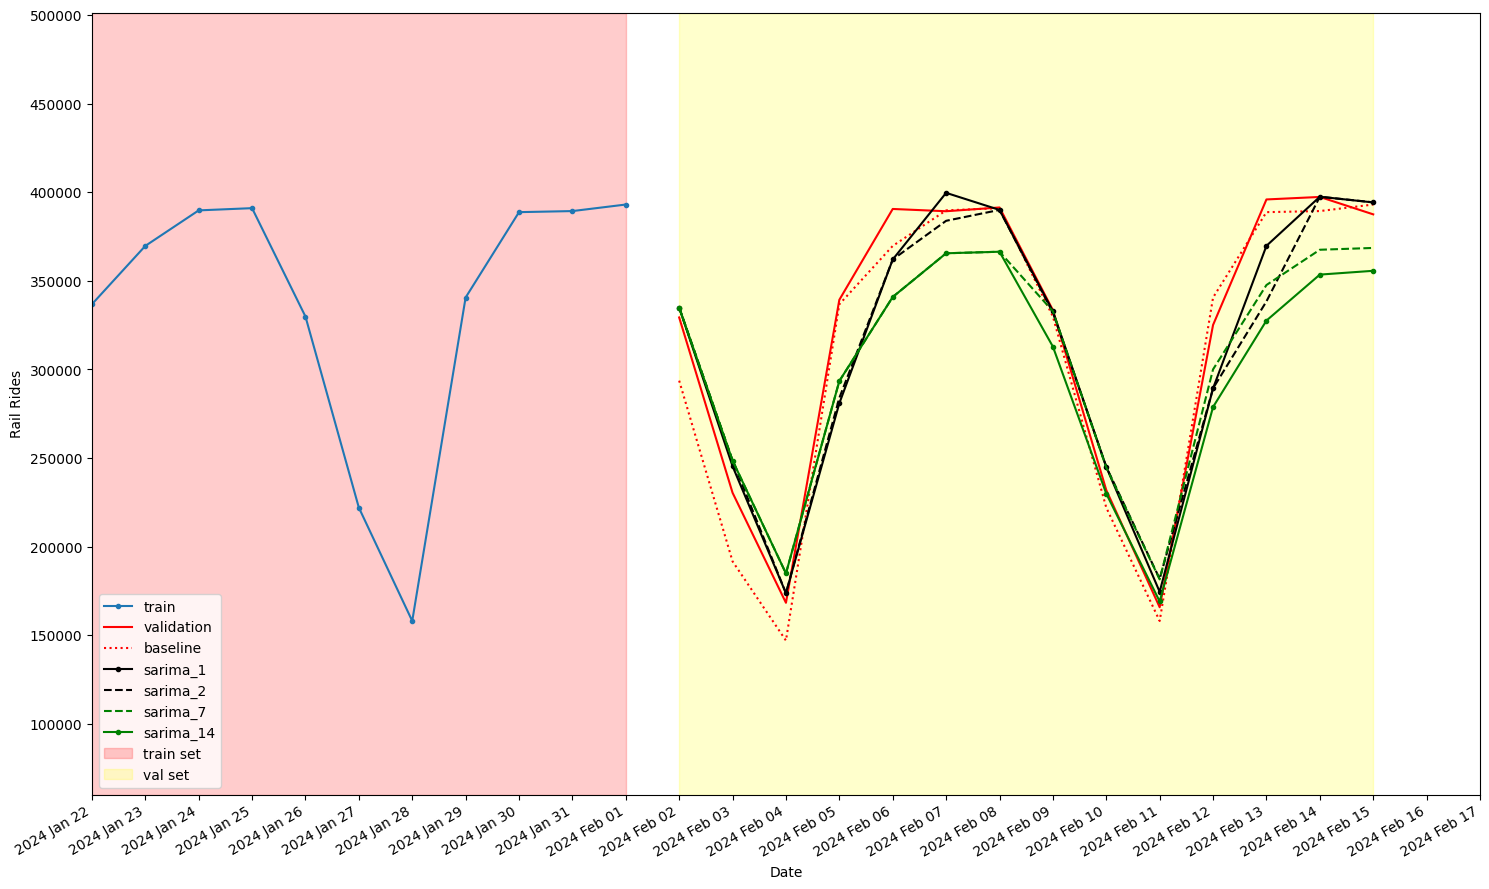

In [65]:
# Visualize the predictions
fig, ax = plt.subplots(figsize=(15,9))

ax.plot(train_set.rail, ".-", label="train")
ax.plot(val_set.rail, "r-", label="validation")
ax.plot(rail_preds.last14values, "r:", label="baseline")
ax.plot(rail_preds.SARIMA_1, "k.-", label="sarima_1")
ax.plot(rail_preds.SARIMA_2, "k--", label="sarima_2")
ax.plot(rail_preds.SARIMA_7, "g--", label="sarima_7")
ax.plot(rail_preds.SARIMA_14, "g.-", label="sarima_14")

ax.set_xlabel('Date')
ax.set_ylabel('Rail Rides')

ax.axvspan(train_set_start, train_set_end, color='red', alpha=0.2, label="train set") # Train set
ax.axvspan(val_set_start, val_set_end, color='yellow', alpha=0.2, label="val set") # Val set


start_date = train_set_end - timedelta(10)
end_date = val_set_end + timedelta(2)

# Zoom
plt.xlim(xmin=start_date, xmax=end_date)

plt.xticks(pd.date_range(start=start_date, end=end_date, freq="D", inclusive='both'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y %b %d'))

ax.legend()
fig.autofmt_xdate()
plt.tight_layout();

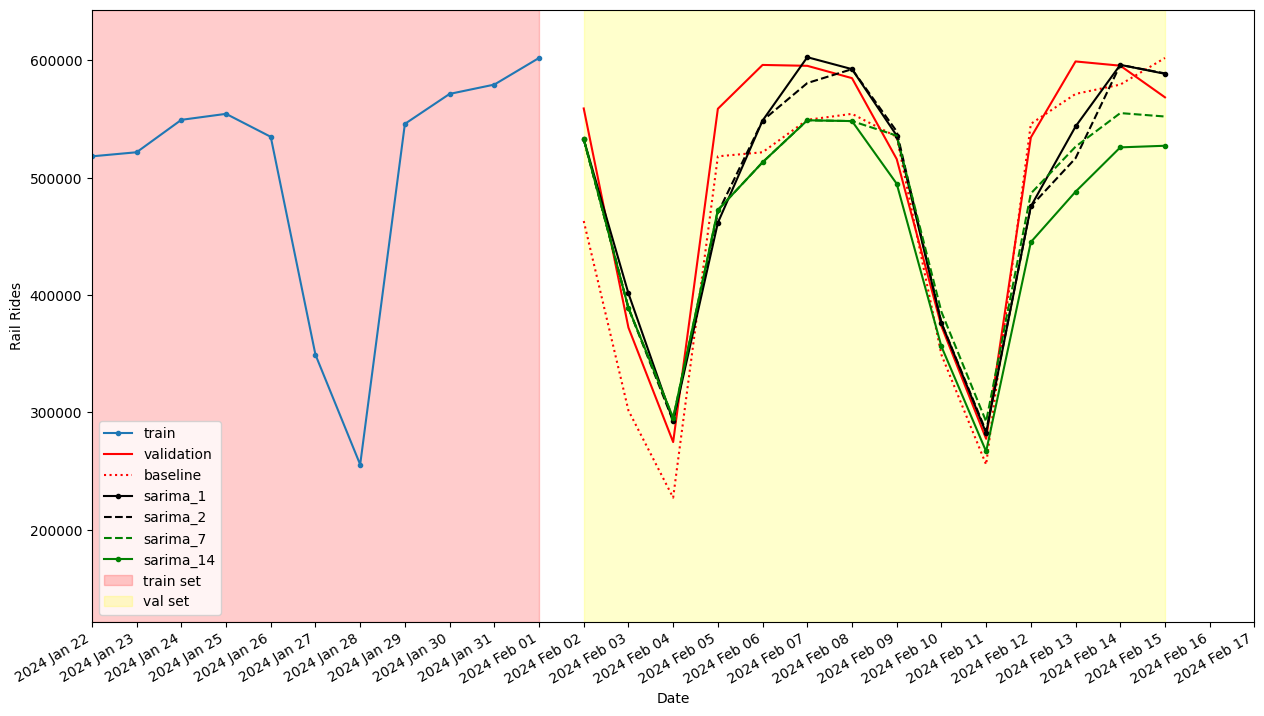

In [66]:
# Visualize the predictions
fig, ax = plt.subplots(figsize=(15,9))

ax.plot(train_set.bus, ".-", label="train")
ax.plot(bus_preds.bus, "r-", label="validation")
ax.plot(bus_preds.last14values, "r:", label="baseline")
ax.plot(bus_preds.SARIMA_1, "k.-", label="sarima_1")
ax.plot(bus_preds.SARIMA_2, "k--", label="sarima_2")
ax.plot(bus_preds.SARIMA_7, "g--", label="sarima_7")
ax.plot(bus_preds.SARIMA_14, "g.-", label="sarima_14")

ax.set_xlabel('Date')
ax.set_ylabel('Rail Rides')

ax.axvspan(train_set_start, train_set_end, color='red', alpha=0.2, label="train set") # Train set
ax.axvspan(val_set_start, val_set_end, color='yellow', alpha=0.2, label="val set") # Val set


start_date = train_set_end - timedelta(10)
end_date = val_set_end + timedelta(2)

# Zoom
plt.xlim(xmin=start_date, xmax=end_date)



plt.xticks(pd.date_range(start=start_date, end=end_date, freq="D", inclusive='both'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y %b %d'))

ax.legend()
fig.autofmt_xdate()
plt.tight_layout;

In [67]:
from sklearn.metrics import mean_squared_error

In [73]:
## Bus

bus_mse_baseline = mean_squared_error(bus_preds.bus, bus_preds.last14values, squared=False)
bus_mse_sarima_1 = mean_squared_error(bus_preds.bus, bus_preds.SARIMA_1, squared=False)
bus_mse_sarima_2 = mean_squared_error(bus_preds.bus, bus_preds.SARIMA_2, squared=False)
bus_mse_sarima_7 = mean_squared_error(bus_preds.bus, bus_preds.SARIMA_7, squared=False)
bus_mse_sarima_14 = mean_squared_error(bus_preds.bus, bus_preds.SARIMA_14, squared=False)

bus_mse_baseline, bus_mse_sarima_1, bus_mse_sarima_2, bus_mse_sarima_7, bus_mse_sarima_14

(46575.65972310921,
 38728.157000471496,
 40475.270231841,
 45843.42258854511,
 57862.2436598441)

In [74]:
## Rail

rail_mse_baseline = mean_squared_error(rail_preds.rail, rail_preds.last14values, squared=False)
rail_mse_sarima_1 = mean_squared_error(rail_preds.rail, rail_preds.SARIMA_1, squared=False)
rail_mse_sarima_2 = mean_squared_error(rail_preds.rail, rail_preds.SARIMA_2, squared=False)
rail_mse_sarima_7 = mean_squared_error(rail_preds.rail, rail_preds.SARIMA_7, squared=False)
rail_mse_sarima_14 = mean_squared_error(rail_preds.rail, rail_preds.SARIMA_14, squared=False)

rail_mse_baseline, rail_mse_sarima_1, rail_mse_sarima_2, rail_mse_sarima_7, rail_mse_sarima_14

(17363.401551210274,
 22146.167211929485,
 25854.44964636195,
 28028.22464550653,
 34401.45842950329)

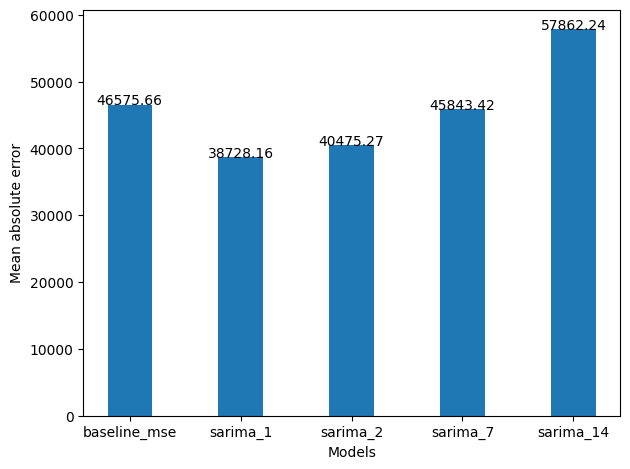

In [80]:
# Visualize
fig, ax = plt.subplots()

x = ['baseline_mse', 'sarima_1', 'sarima_2', 'sarima_7', 'sarima_14']
y = [bus_mse_baseline, bus_mse_sarima_1, bus_mse_sarima_2, bus_mse_sarima_7, bus_mse_sarima_14]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('Mean absolute error')
# ax.set_ylim(0, 4)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.1, s=str(round(value,2)), ha='center')
    
plt.tight_layout();

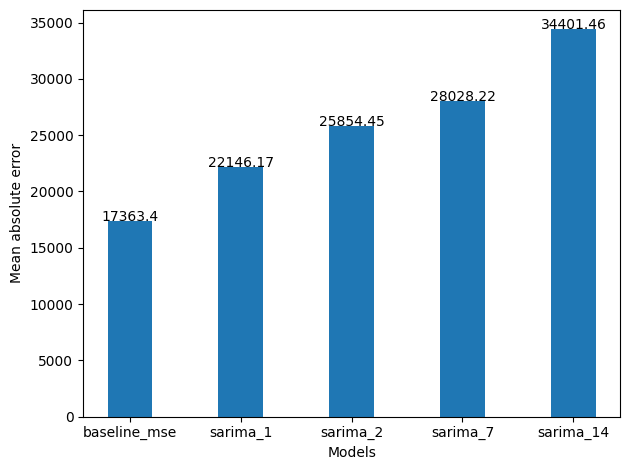

In [81]:
# Visualize
fig, ax = plt.subplots()

x = ['baseline_mse', 'sarima_1', 'sarima_2', 'sarima_7', 'sarima_14']
y = [rail_mse_baseline, rail_mse_sarima_1, rail_mse_sarima_2, rail_mse_sarima_7, rail_mse_sarima_14]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('Mean absolute error')
# ax.set_ylim(0, 4)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.1, s=str(round(value,2)), ha='center')
    
plt.tight_layout();